In [1]:
# some imports
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"


# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"


# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.rc('font', size=12)
plt.rc('figure', figsize = (12, 5))

# Settings for the visualizations
#import seaborn as sns
#sns.set_style("whitegrid")
#sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2,'font.family': [u'times']})

import pandas as pd
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 50)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
# Others
import cv2
import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split
from skimage.io import imread

 ## Import data

In [2]:
# Paths
X_train_path = './dataset/train/train/train/'
X_test_path = './dataset/test/test/test/'
dataset_csv = './dataset/train.txt'
dataset_train = './dataset/train/train'
dataset_test = './dataset/test/test'

In [27]:
_STOP = 6000
def preprocess(img_paths,dataset_path,preprocess_img_method = None):
    print("loading data")
    data = []
    stop = 0
    for img_path in tqdm.tqdm(img_paths):
        path = os.path.realpath(os.path.join(dataset_path,img_path[1:]))
        img = imread(path)
        if preprocess_img_method:
            img = preprocess_img_method(img)
        else:
            # img = cv2.resize(img,(224,224),cv2.INTER_AREA)
            img = img / 255. #normalize
        data.append(img)
        stop += 1
        if(stop == _STOP):
            break
    print("loading data done")
    return data

def preprocess_img_vgg(img):
    return preprocess_input(img)


In [28]:
df = pd.read_csv(dataset_csv, delimiter='\ ', header=None)
y_train_full = np.array(df[1])[:_STOP]
img_paths = df[0]
X_train_full = preprocess(df[0], dataset_train,preprocess_img_method=None)
X_train_full= np.stack(X_train_full)

C:\ProgramData\Anaconda3\envs\tfgpu\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


loading data


 40%|███▉      | 5999/15000 [00:05<00:08, 1059.81it/s]


loading data done


In [5]:
print(max(y_train_full))

29


In [32]:
# Split dataset
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)
X_train = X_train.astype("float32")
X_valid = X_valid.astype("float32")
y_train = y_train.astype("float32")
y_valid = y_valid.astype("float32")

In [7]:
print(X_train.shape)

(2250, 158, 158)


In [8]:
print(X_train[0])

[[0.33333334 0.30980393 0.34901962 ... 0.22745098 0.2        0.24705882]
 [0.25882354 0.25490198 0.35686275 ... 0.2784314  0.1764706  0.3019608 ]
 [0.29803923 0.31764707 0.3764706  ... 0.3019608  0.2509804  0.2627451 ]
 ...
 [0.39607844 0.42745098 0.40784314 ... 0.59607846 0.6039216  0.654902  ]
 [0.43137255 0.43529412 0.4392157  ... 0.5921569  0.6156863  0.654902  ]
 [0.43137255 0.43529412 0.44313726 ... 0.60784316 0.62352943 0.6862745 ]]


In [9]:
print(len(X_train))
print(len(y_train))
print(len(X_valid))
print(len(y_valid))

2250
2250
750
750


In [10]:
print(len(X_train))
print(X_train[0].shape)
print(type(X_train))
print(X_train.shape)
print(type(X_train[0]))

2250
(158, 158)
<class 'numpy.ndarray'>
(2250, 158, 158)
<class 'numpy.ndarray'>


[21. 13. 22. 28.  9.  2. 18. 10. 25. 11.]
29


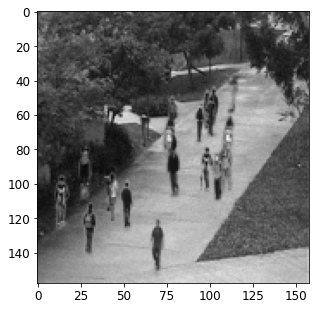

In [11]:
print(y_train[10:20])
plt.imshow(X_train[12], cmap='gray')

no_classes = np.max(y_train_full)
print(no_classes)

## Model

In [20]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[158, 158]))
model.add(tf.keras.layers.Dense(250, activation="relu",kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(150, activation="relu",kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(50, activation="relu",kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(no_classes+1, activation="softmax"))

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 24964)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 250)               6241250   
_________________________________________________________________
dense_9 (Dense)              (None, 150)               37650     
_________________________________________________________________
dense_10 (Dense)             (None, 50)                7550      
_________________________________________________________________
dense_11 (Dense)             (None, 30)                1530      
Total params: 6,287,980
Trainable params: 6,287,980
Non-trainable params: 0
_________________________________________________________________


In [22]:
# define loss function, optimizer and metrics
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

# train the model and validate using val data
history = model.fit(X_train, y_train, epochs=150,
                    validation_data=(X_valid, y_valid))


Epoch 1/150
71/71 [==============================] - 0s 6ms/step - loss: 3.4330 - accuracy: 0.0373 - val_loss: 3.4135 - val_accuracy: 0.0320
Epoch 2/150
71/71 [==============================] - 0s 4ms/step - loss: 3.4054 - accuracy: 0.0360 - val_loss: 3.4014 - val_accuracy: 0.0293

In [15]:
# sgd = tf.keras.optimizers.SGD(lr = 1e-4, decay = (5*1e-4), momentum = 0.95)
model.compile(optimizer="sgd", loss="mse", metrics=['mse'])



In [62]:
history = model.fit(x=X_train,y=y_train,epochs=100, verbose=1,validation_data=(X_valid, y_valid))

Epoch 1/100
71/71 [==============================] - 0s 6ms/step - loss: 279.4566 - mse: 279.4566 - val_loss: 290.0049 - val_mse: 290.0049
Epoch 2/100
71/71 [==============================] - 0s 5ms/step - loss: 279.4566 - mse: 279.4566 - val_loss: 290.0049 - val_mse: 290.0049

<AxesSubplot:>

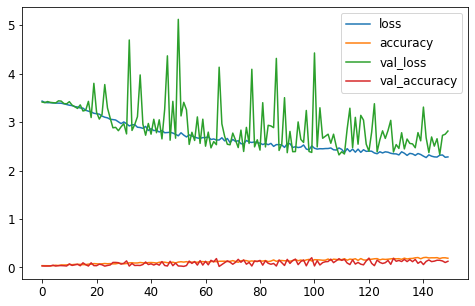

In [23]:
pd.DataFrame(history.history).plot(figsize=(8, 5))

In [30]:
# evaluate the model using test data
X_test = X_train_full[5000:6000]
y_test = y_train_full[5000:6000]
print(X_test.shape)

X_test = X_test.astype("float32")
y_test = y_test.astype("float32")

(1000, 158, 158)


In [31]:
model.evaluate(x=X_test, y=y_test,verbose=2)



32/32 - 0s - loss: 2.7795 - accuracy: 0.1310


[2.7795445919036865, 0.13099999725818634]